In [1]:
import multiprocessing as mp
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import mabs

sns.set_theme()

n = 1000
ps = np.linspace(0, 1, 100)

bernoulli_priors = np.array(
    [[[1, 1], [1, 1]], [[1, 1], [1, 3]], [[10, 10], [10, 10]], [[10, 10], [10, 30]]]
)

In [4]:
def experiment(p, n, prior_a, prior_b):
    exp_regret = np.empty(100)
    for i in range(100):
        arms = [
            mabs.arms.BernoulliArm(0.5),
            mabs.arms.BernoulliArm(p),
        ]
        priors = {
            arms[0]: {"alpha": prior_a[0], "beta": prior_a[1]},
            arms[1]: {"alpha": prior_b[0], "beta": prior_b[1]},
        }
        env = mabs.envs.bayesian.ThompsonSampling("bernoulli")
        env.arms = arms
        env.prior_params = priors

        for _ in range(n):
            env.act()
        exp_regret[i] = env.regret

    return exp_regret, p, str(prior_a) + str(prior_b)

In [5]:
regrets = []
args = []

for prior in bernoulli_priors:
    args += [(p, n, prior[0], prior[1]) for p in ps]
with mp.Pool(32) as p:
    result = p.starmap(experiment, args)

with open("result.pkl", "wb") as f:
    pickle.dump(result, f)

In [6]:
with open("result.pkl", "rb") as f:
    result_raw = pickle.load(f)

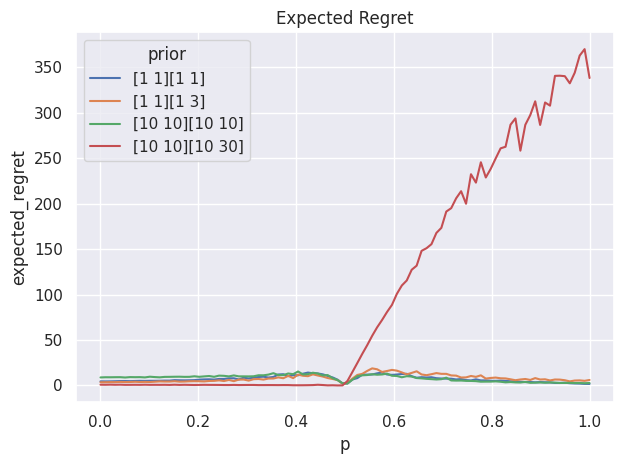

In [7]:
mean_regret = [(regret.mean(), p, prior) for regret, p, prior in result_raw]
mean_regret_df = pd.DataFrame(mean_regret, columns=["expected_regret", "p", "prior"])
sns.lineplot(data=mean_regret_df, x="p", y="expected_regret", hue="prior")
plt.title("Expected Regret")
plt.tight_layout()
plt.savefig("ts_bernoulli_mean.pdf")

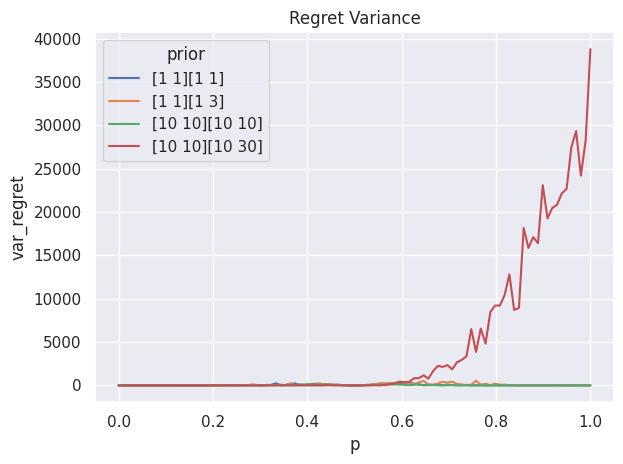

In [8]:
var_regret = [(regret.var(), p, prior) for regret, p, prior in result_raw]
var_regret_df = pd.DataFrame(var_regret, columns=["var_regret", "p", "prior"])
sns.lineplot(data=var_regret_df, x="p", y="var_regret", hue="prior")
plt.title("Regret Variance")
plt.tight_layout()
plt.savefig("ts_bernoulli_var.pdf")